## Importação das bibliotecas

Aqui são imoportadas as bibliotecas relacionadas ao Pytorch para carregar e utilizar um modelo para inferência. também são utilizadas bibliotecas do matplot, seaborn e outras para plotar gráficos e fazer a auditoria.

In [9]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset

# Plots e avaliação
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import glob
import pandas as pd

# Ignora todos os avisos
import warnings
warnings.filterwarnings("ignore")

## Dicionário de Configuração

Como no código de treinamento, alterar esse dicionário altera todo o _pipeline_ de execução, facilitando alterações.

In [ ]:
CONFIG = {
    'num_classes': 7,
    'embedding_size': 512,
    'model_name': 'vit_b_16',
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'class_names': ['Black', 'East Asian', 'Indian', 'Latino_Hispanic', 'Middle Eastern', 'Southeast Asian', 'White'] # Mesma ordem do treino
}

## Classe ArcFace

Usado como parte do modelo para reconhecimento de faces.

In [ ]:
class ArcFaceLayer(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50):
        super(ArcFaceLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label=None):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        if label is None:
            return cosine * self.s
        # (lógica de treino omitida pois não será usada, mas o método deve existir)
        return cosine * self.s

class ModelWrapper(nn.Module):
    def __init__(self, base_model, input_features, num_classes):
        super(ModelWrapper, self).__init__()
        self.features = base_model
        self.embedding_layer = nn.Linear(input_features, CONFIG['embedding_size'])
        self.bn = nn.BatchNorm1d(CONFIG['embedding_size'])
        # Nota: Instanciamos com use_arcface=True se o modelo foi salvo assim, 
        # mas na inferência o ArcFace age como uma camada linear normalizada.
        self.classifier = ArcFaceLayer(CONFIG['embedding_size'], num_classes)
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        embeddings = self.embedding_layer(x)
        embeddings = self.bn(embeddings)
        logits = self.classifier(embeddings) # Sem label = inferência
        return logits

## Carregar pesos do modelo

Neste trecho de código, carregamos um modelo os pesos obtidos no treinamento no dataset FairFace.

In [ ]:
def load_trained_model(path):
    print(f"Carregando arquitetura {CONFIG['model_name']}...")
    if CONFIG['model_name'] == 'vit_b_16':
        base = models.vit_b_16(weights=None) # Pesos virão do arquivo .pth
        num_ftrs = base.heads.head.in_features
        base.heads = nn.Identity()
    
    model = ModelWrapper(base, num_ftrs, CONFIG['num_classes'])
    
    # Carrega os pesos treinados
    state_dict = torch.load(path, map_location=CONFIG['device'])
    
    try:
        model.load_state_dict(state_dict)
        print("Pesos carregados com sucesso!")
    except Exception as e:
        print(f"Erro ao carregar pesos (verifique se a arquitetura é idêntica): {e}")
    
    return model.to(CONFIG['device']).eval()

## Carregar _Dataset_

Aqui, um _dataset_ é carregado para auditoria. Só precisamos das imagens, pois supomos que o modelo não tem a anotação referente à raças/etnias e dependemos apenas do conhecimento do modelo para fazer esta distinção.

In [10]:
class UnlabeledDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.file_list = glob.glob(os.path.join(folder_path, "*.jpg")) + \
                         glob.glob(os.path.join(folder_path, "*.png"))
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_path # Retorna o caminho para sabermos quem é quem

## Inferência

Nesta secção do código, todas as imagens passam por uma transformação adequada para 224x224 pixels e carregadas no dispositivo (GPU ou CPU) para que o modelo realize a inferência, classificando cada imagem com uma das labels conhecidas pelo modelo.

In [ ]:
def audit_dataset(dataset_folder, model_path):
    # Transformação igual às imagens que alimentaram o modelo durante o treino
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    
    dataset = UnlabeledDataset(dataset_folder, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)
    
    model = load_trained_model(model_path)
    
    print(f"\nIniciando auditoria em {len(dataset)} imagens...")
    
    results = []
    
    with torch.no_grad():
        for inputs, paths in dataloader:
            inputs = inputs.to(CONFIG['device'])
            
            # Inferência
            logits = model(inputs)
            
            # Probabilidades (Softmax) para ver confiança (opcional)
            probs = F.softmax(logits, dim=1)
            confidences, preds = torch.max(probs, 1)
            
            for path, pred, conf in zip(paths, preds, confidences):
                results.append({
                    'arquivo': os.path.basename(path),
                    'predicao_idx': pred.item(),
                    'etnia_predita': CONFIG['class_names'][pred.item()],
                    'confianca': conf.item()
                })

    # Cria DataFrame
    df = pd.DataFrame(results)
    return df

### Auditoria

Após a inferência do modelo, os dados são utilizados para a realização de gráficos que mostram a distribuição relativa e absoluta das etnias presentes no _dataset_. Logo após, definimos uma métrica para determinar uma subrepresentação. Se uma dada etnia tiver a representação relativa menor que (1/total de imagens do _dataset_), então ela é considerada subrepresentada. Caso ela seja metade desse valor, ela é criticamente subrepresentada. Essas informações são plotadas em formato de texto e, adicionalmente, é gerado um arquivo CSV caso seja necessário uma auditoria manual ou qualquer outra extração de informação.

In [ ]:
def generate_deia_report(df):
    # Contagem absoluta e porcentagem
    counts = df['etnia_predita'].value_counts()
    percentages = df['etnia_predita'].value_counts(normalize=True) * 100
    
    print("\n" + "-"*40)
    print("RELATÓRIO DE REPRESENTATIVIDADE")
    print("-"*40)
    print(percentages.to_string(float_format="%.2f%%"))
    
    # Definição de Cores para o Gráfico (Visualmente distintas)
    colors = sns.color_palette('pastel')[0:5]
    
    plt.figure(figsize=(14, 6))
    
    # Gráfico 1: Barras (Quantidade Absoluta)
    plt.subplot(1, 2, 1)
    ax = sns.countplot(data=df, x='etnia_predita', order=CONFIG['class_names'], palette=colors)
    plt.title('Distribuição Absoluta por Etnia')
    plt.ylabel('Quantidade de Imagens')
    plt.xlabel('Etnia Predita')
    plt.xticks(rotation=45)
    
    # Adiciona números no topo das barras
    for container in ax.containers:
        ax.bar_label(container)

    # Gráfico 2: Pizza (Representatividade %) 
    plt.subplot(1, 2, 2)
    # Garante que a ordem da pizza segue a ordem das cores/classes
    pie_data = [counts.get(cls, 0) for cls in CONFIG['class_names']]
    
    plt.pie(pie_data, labels=CONFIG['class_names'], autopct='%1.1f%%', colors=colors, startangle=140)
    plt.title('Percentual de Representatividade')

    plt.tight_layout()
    plt.show()

    # Alerta de Subrepresentação (Regra de Ouro DEIA)
    # Se uma classe tiver menos de 1/N das imagens (com tolerância), é subrepresentada.
    limiar_ideal = 100 / len(CONFIG['class_names']) # Ex: 20% para 5 classes
    limiar_critico = limiar_ideal * 0.5 # Se tiver menos da metade do ideal
    
    print("\n--- ANÁLISE DE SUBREPRESENTAÇÃO ---")
    for etnia in CONFIG['class_names']:
        pct = percentages.get(etnia, 0)
        if pct < limiar_critico:
            print(f"[ALERTA CRÍTICO] A etnia '{etnia}' está severamente subrepresentada ({pct:.2f}%).")
        elif pct < limiar_ideal:
             print(f"[ATENÇÃO] A etnia '{etnia}' está abaixo da distribuição equilibrada ({pct:.2f}%).")
        else:
            print(f"[OK] A etnia '{etnia}' tem boa representatividade ({pct:.2f}%).")
            
    # Salva CSV para auditoria manual
    df.to_csv('relatorio_auditoria_vies.csv', index=False)
    print("\nArquivo 'relatorio_auditoria_vies.csv' gerado com sucesso.")

## _Pipeline_ de execução

Após toda a compartimentalização do código, a classe _main_ é responsável por executar todos os processos. Desde o carregamento do modelo e do _dataset_, até a obtenção da auditoria. Para uma pasta com 23 mil imagens, a execução demora cerca de um minuto e meio e consome 3Gb de VRAM.

Carregando arquitetura vit_b_16...
Pesos carregados com sucesso!

Iniciando auditoria em 23708 imagens...

RELATÓRIO DE REPRESENTATIVIDADE
etnia_predita
White             34.70%
Middle Eastern    21.16%
Black             12.76%
East Asian        11.95%
Indian            11.14%
Latino_Hispanic    7.27%
Southeast Asian    1.01%


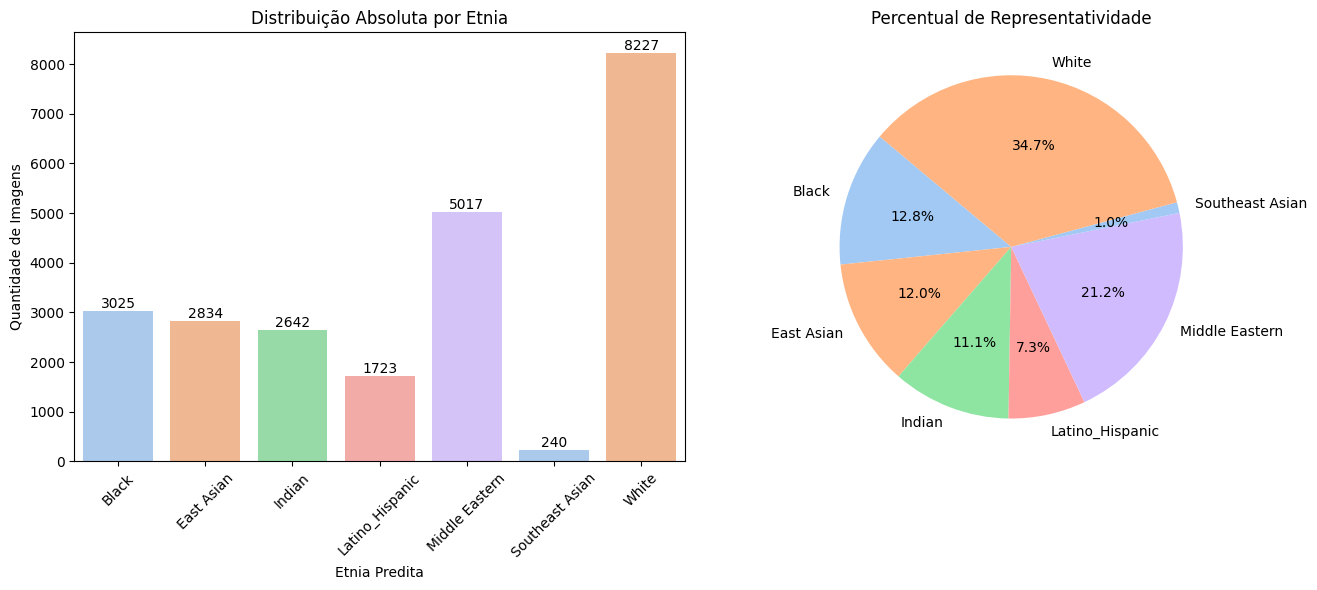


--- ANÁLISE DE SUBREPRESENTAÇÃO ---
[ATENÇÃO] A etnia 'Black' está abaixo da distribuição equilibrada (12.76%).
[ATENÇÃO] A etnia 'East Asian' está abaixo da distribuição equilibrada (11.95%).
[ATENÇÃO] A etnia 'Indian' está abaixo da distribuição equilibrada (11.14%).
[ATENÇÃO] A etnia 'Latino_Hispanic' está abaixo da distribuição equilibrada (7.27%).
[OK] A etnia 'Middle Eastern' tem boa representatividade (21.16%).
[ALERTA CRÍTICO] A etnia 'Southeast Asian' está severamente subrepresentada (1.01%).
[OK] A etnia 'White' tem boa representatividade (34.70%).

Arquivo 'relatorio_auditoria_vies.csv' gerado com sucesso.


In [11]:
if __name__ == "__main__":
    # Caminho onde está salvo o arquivo .pth
    MODEL_PATH = f'{CONFIG["model_name"]}.pth' 
    
    # Pasta com as novas imagens (sem labels) que serão auditadas
    NEW_DATASET_DIR = "UTKFace" 
    
    if os.path.exists(MODEL_PATH) and os.path.exists(NEW_DATASET_DIR):
        df_resultados = audit_dataset(NEW_DATASET_DIR, MODEL_PATH)
        generate_deia_report(df_resultados)
    else:
        print("Verifique os caminhos do modelo e da pasta de imagens.")